# Uniform Rotation for Input Point Cloud

In order for the block creation to work there are two main possibilities that come to mind in a 3D dataset. <br>
<br>
- Voxelization <br>
- Blocking (kind of 2D voxelization)<br>
<br>
While both approaches are quite similar in their inner logic, the difference is the suitability for the respective dataset. As we are most likely working with rock face structures where the bounding box would be defined more as a cuboid than a cubus, voxelization - for which several automatic methods already do exist - might not be the best choice when one wants to create uniform point sampling throughout the sample. Therefore, our approach of blocking, which could be described as a 2D-voxelization, is highly dependent on the direction of the dataset. In order to not incorporate any bias, we would rotate and translate the input point cloud to the origin and then create blocks as a 2D-net in the dimension with the least distance. <br>
While a sensible logic for the blocking already is in place and theoretically functional, the rotation or directionality of the blocking remains the issue. For this there are also mutliple approaches:<br>
<br>
- Determine axis of the bounding box and create blocks within (feels chaotic & unnecessarily complicated)<br>
<br>
- Rotate bounding box of the input point cloud to origin and block then<br>
        - Rotation-matrix of bounding box axes -> Multiplication to rotate input point cloud (!Gimbal lock!)<br>
        - Quaternion-rotation of bounding box axes (No risk of Gimbal lock)<br>

## Imports, Functions and Variables needed

In [46]:
# For paths
import os 

# For data processing
import torch
import numpy as np
from torch.utils.data import Dataset
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

# Setting the root for this repo
ROOT = os.path.realpath("..")

# Creating/ Making the point cloud
def makePC(point_data, color_data=np.array([])):
    pcd = o3d.geometry.PointCloud() #Create PC object
    pcd.points = o3d.utility.Vector3dVector(point_data) #Give coordinates
    #Coloring the PC
    if len(color_data) == 0:
        pcd.paint_uniform_color([1, 0, 0])
    else:
        pcd.colors = o3d.utility.Vector3dVector(color_data)
    return pcd

# Axis alignment of given point cloud
def axisAlignment(main_pcd):
    """Rotating/axis aligning the pointcloud
    input: main_pcd = initial pointcloud (open3d.geometry.PointCloud object)
    output: main_pcd = rotated pointcloud (open3d.geometry.PointCloud object)"""
    bbox = main_pcd.get_oriented_bounding_box()
    inverse_R = np.linalg.inv(bbox.R)
    main_pcd.rotate(inverse_R)
    return main_pcd

## Data Loading

In [17]:
# Path creation for easier loading
input_pc_path = ROOT + "/data/testdata/data_labelled_int.npy"

# Loading relevant data
input_pc = np.load(input_pc_path) #ndarray
input_pc_points, input_pc_labels = input_pc[:, 0:6], input_pc[:, 6]

# Print checks for the input data
print("--------- Print checks for input data ---------")
print(f"The input data consists of {len(input_pc)} points.")
print(f"The input data is of shape: {input_pc.shape}")
print(f"The input data contains {np.count_nonzero(input_pc_labels)} fracture points.")
print(f"Therefore, {len(input_pc) - np.count_nonzero(input_pc_labels)} points are non-fracture points in the entire sample.")
print(f"This means that {np.round(np.count_nonzero(input_pc_labels) / len(input_pc) * 100, 4)}% of all points are fracture points")
print('---------- Print Check for X-Coordinate ----------')
print(f"The minimum value in x-direction is: {np.min(input_pc_points[:, 0])}")
print(f"The maximum value in x-direction is: {np.max(input_pc_points[:, 0])}")
print(f'The mean value in x-direction is: {np.mean(input_pc_points[:, 0])}')
print(f'The variance in x-direction is: {np.var(input_pc_points[:, 0])}')
print('---------- Print Check for Y-Coordinate ----------')
print(f"The minimum value in y-direction is: {np.min(input_pc_points[:, 1])}")
print(f"The maximum value in y-direction is: {np.max(input_pc_points[:, 1])}")
print(f'The mean value in y-direction is: {np.mean(input_pc_points[:, 1])}')
print(f'The variance in y-direction is: {np.var(input_pc_points[:, 1])}')
print('---------- Print Check for Z-Coordinate ----------')
print(f"The minimum value in z-direction is: {np.min(input_pc_points[:, 2])}")
print(f"The maximum value in z-direction is: {np.max(input_pc_points[:, 2])}")
print(f'The mean value in z-direction is: {np.mean(input_pc_points[:, 2])}')
print(f'The variance in z-direction is: {np.var(input_pc_points[:, 2])}')

--------- Print checks for input data ---------
The input data consists of 662525 points.
The input data is of shape: (662525, 7)
The input data contains 8199 fracture points.
Therefore, 654326 points are non-fracture points in the entire sample.
This means that 1.2375% of all points are fracture points
---------- Print Check for X-Coordinate ----------
The minimum value in x-direction is: 0.0
The maximum value in x-direction is: 288.8758689999813
The mean value in x-direction is: 165.61342139521435
The variance in x-direction is: 4299.517704445124
---------- Print Check for Y-Coordinate ----------
The minimum value in y-direction is: 0.0
The maximum value in y-direction is: 226.1995279993862
The mean value in y-direction is: 104.99673473649423
The variance in y-direction is: 2716.543347393639
---------- Print Check for Z-Coordinate ----------
The minimum value in z-direction is: 0.0
The maximum value in z-direction is: 177.267736
The mean value in z-direction is: 74.85754577858197
The

## Display XYZ-Axis in Point Cloud visualization?

Can we do this? Otherwise I would display it in matplotlib once before the rotation and once after.

## Input point cloud visualization

In [21]:
# Assigning the coordinates
input_points = np.stack([input_pc_points[:, 0], 
                         input_pc_points[:, 1], 
                         input_pc_points[:, 2]], axis=1)
# Assigning color channels
red_c   = np.array(input_pc_points[:, 3])
green_c = np.array(input_pc_points[:, 4])
blue_c  = np.array(input_pc_points[:, 5])
# Converting color channels to [0, 1] range
red_c   = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
blue_c  = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
# Creating color data
color_data = np.stack([red_c, green_c, blue_c], axis=1)

# Creating axes as points in the point cloud
axes_num_points = 10000
axes_val_limit = 200
axes_val_range = np.array(np.linspace(-axes_val_limit, axes_val_limit, axes_num_points))
x_axis = np.stack([axes_val_range, np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1)
y_axis = np.stack([np.zeros(axes_num_points), axes_val_range, np.zeros(axes_num_points)], axis=1)
z_axis = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), axes_val_range], axis=1)
x_axis_color = np.stack([np.ones(axes_num_points), np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1) #RED
y_axis_color = np.stack([np.zeros(axes_num_points), np.ones(axes_num_points), np.zeros(axes_num_points)], axis=1) #GREEN
z_axis_color = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), np.ones(axes_num_points)], axis=1) #BLUE
axes_colors = np.concatenate([x_axis_color, y_axis_color, z_axis_color], axis=0)

# Append to points and color data
input_points_with_axes = np.concatenate([input_points, x_axis, y_axis, z_axis], axis=0)
#color_data = np.concatenate([color_data, axes_colors], axis=0)

# Make the point clouds to be displayed
viz_pcd = makePC(input_points, color_data)
viz_axes = makePC(np.concatenate([x_axis, y_axis, z_axis], axis=0), axes_colors)

# Print check for point cloud
print("------ Print check for input point cloud ------")
print(f"The input point cloud consists of {len(viz_pcd.points)} number of points.")
print(f"The minimum coordinates of the point cloud are: {np.amin(np.asarray(viz_pcd.points), axis=0)}")
print(f"The maximum coordinates of the point cloud are: {np.amax(np.asarray(viz_pcd.points), axis=0)}")
# Minimum will be [0, 0, 0] as the input data has been shifted already

# Cropping the point cloud using bounding boxes
bbox = viz_pcd.get_oriented_bounding_box()
bbox.color = (0, 1, 0) #bbox in green
viz_pcd_cropped = viz_pcd.crop(bbox)

# Print check for cropped point cloud
print("------ Print check for cropped input point cloud ------")
print(f"The cropped point cloud consists of {len(viz_pcd_cropped.points)} number of points.")
print(f"The bounding box cropping removed {len(viz_pcd.points) - len(viz_pcd_cropped.points)} points.")
print(f"The minimum coordinates of the cropped point cloud are: {np.amin(np.asarray(viz_pcd_cropped.points), axis=0)}")
print(f"The maximum coordinates of the point cloud are: {np.amax(np.asarray(viz_pcd_cropped.points), axis=0)}")
# Minimum will be [0, 0, 0] as the input data has been shifted already

# Visualizing the point cloud
o3d.visualization.draw([viz_pcd_cropped, bbox, viz_axes])

------ Print check for input point cloud ------
The input point cloud consists of 662525 number of points.
The minimum coordinates of the point cloud are: [0. 0. 0.]
The maximum coordinates of the point cloud are: [288.875869 226.199528 177.267736]
------ Print check for cropped input point cloud ------
The cropped point cloud consists of 662522 number of points.
The bounding box cropping removed 3 points.
The minimum coordinates of the cropped point cloud are: [0. 0. 0.]
The maximum coordinates of the point cloud are: [288.875869 226.199528 177.267736]


## Move Input Point Cloud to Center and rotate there

In [ ]:
##################################### DATALOADING #########################################
# Path creation for easier loading
input_pc_path = ROOT + "/data/testdata/data_labelled_int.npy"
# Loading relevant data
input_pc = np.load(input_pc_path) #ndarray
input_pc_points, input_pc_labels = input_pc[:, 0:6], input_pc[:, 6]
# Print checks for the input data
print("--------- Print checks for input data ---------")
print(f"The input data consists of {len(input_pc)} points.")
print(f"The input data is of shape: {input_pc.shape}")
print(f"The input data contains {np.count_nonzero(input_pc_labels)} fracture points.")
print(f"Therefore, {len(input_pc) - np.count_nonzero(input_pc_labels)} points are non-fracture points in the entire sample.")
print(f"This means that {np.round(np.count_nonzero(input_pc_labels) / len(input_pc) * 100, 4)}% of all points are fracture points")
print('---------- Print Check for X-Coordinate ----------')
print(f"The minimum value in x-direction is: {np.min(input_pc_points[:, 0])}")
print(f"The maximum value in x-direction is: {np.max(input_pc_points[:, 0])}")
print(f'The mean value in x-direction is: {np.mean(input_pc_points[:, 0])}')
print(f'The variance in x-direction is: {np.var(input_pc_points[:, 0])}')
print('---------- Print Check for Y-Coordinate ----------')
print(f"The minimum value in y-direction is: {np.min(input_pc_points[:, 1])}")
print(f"The maximum value in y-direction is: {np.max(input_pc_points[:, 1])}")
print(f'The mean value in y-direction is: {np.mean(input_pc_points[:, 1])}')
print(f'The variance in y-direction is: {np.var(input_pc_points[:, 1])}')
print('---------- Print Check for Z-Coordinate ----------')
print(f"The minimum value in z-direction is: {np.min(input_pc_points[:, 2])}")
print(f"The maximum value in z-direction is: {np.max(input_pc_points[:, 2])}")
print(f'The mean value in z-direction is: {np.mean(input_pc_points[:, 2])}')
print(f'The variance in z-direction is: {np.var(input_pc_points[:, 2])}')
#############################################################################################

##################################### POINT AND COLOR CREATION #########################################
# Assigning the coordinates
input_points = np.stack([input_pc_points[:, 0], 
                         input_pc_points[:, 1], 
                         input_pc_points[:, 2]], axis=1)
# Assigning color channels
red_c   = np.array(input_pc_points[:, 3])
green_c = np.array(input_pc_points[:, 4])
blue_c  = np.array(input_pc_points[:, 5])
# Converting color channels to [0, 1] range
red_c   = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
blue_c  = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
# Creating color data
color_data = np.stack([red_c, green_c, blue_c], axis=1)
#############################################################################################

############################### POINT CLOUD CREATION ###############################
viz_pcd = makePC(input_points, color_data)
# Cropping the point cloud using bounding boxes
bbox = viz_pcd.get_oriented_bounding_box()
bbox.color = (0, 1, 0) #bbox in green
viz_pcd_cropped = viz_pcd.crop(bbox)
# Shifting point cloud to origin
bbox_center = viz_pcd.get_center()
# Centering the point cloud on the origin
viz_pcd.points = viz_pcd.points - bbox_center
# 


In [64]:
# Checking with randomly created points
sequence_to_sample_from = np.linspace(1, 100, 100).tolist()
x_coords = np.array(random.sample(sequence_to_sample_from, 20))
y_coords = np.array(random.sample(sequence_to_sample_from, 20))
z_coords = np.array(random.sample(sequence_to_sample_from, 20))
# Concatenate point coords
point_coords = np.concatenate([x_coords.reshape(-1,1), 
                               y_coords.reshape(-1,1), 
                               z_coords.reshape(-1,1)], 
                               axis=1)
# Create color array for points
point_colors = np.concatenate([np.zeros(20).reshape(-1,1), 
                               np.zeros(20).reshape(-1,1), 
                               np.ones(20).reshape(-1,1)], 
                              axis=1)
# makePC
points_pc = makePC(point_coords, point_colors)
# Get center of pc
points_center = points_pc.get_center()
# Translate pc to origin
shifted_point_coords = np.array(points_pc.points) - points_center
# Create new pc for shifted points
shiftted_points_pc = makePC(shifted_point_coords, point_colors)
# get bounding box
points_bbox = shiftted_points_pc.get_oriented_bounding_box()
# Setting color for bounding box
points_bbox.color = (0, 1, 0)
# get box points from bbox
bbox_points = np.asarray(points_bbox.get_box_points())
# create colors for bounding box points
bbox_points_colors = [[1, 0, 0], 
                    [0, 0, 1], 
                    [0, 0, 1], 
                    [0, 0, 1], 
                    [0, 0, 1], 
                    [0, 0, 1],
                    [0, 0, 1], 
                    [0, 0, 1]]
# make pc with bbox points
bbox_points_pc = makePC(bbox_points, bbox_points_colors)

# Creating axes as points in the point cloud
axes_num_points = 10000
axes_val_limit = 100
axes_val_range = np.array(np.linspace(-axes_val_limit, axes_val_limit, axes_num_points))
x_axis = np.stack([axes_val_range, np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1)
y_axis = np.stack([np.zeros(axes_num_points), axes_val_range, np.zeros(axes_num_points)], axis=1)
z_axis = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), axes_val_range], axis=1)
x_axis_color = np.stack([np.ones(axes_num_points), np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1) #RED
y_axis_color = np.stack([np.zeros(axes_num_points), np.ones(axes_num_points), np.zeros(axes_num_points)], axis=1) #GREEN
z_axis_color = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), np.ones(axes_num_points)], axis=1) #BLUE
axes_colors = np.concatenate([x_axis_color, y_axis_color, z_axis_color], axis=0)
axes_points = np.concatenate([x_axis, y_axis, z_axis], axis=0)
axes_pc = makePC(axes_points, axes_colors)

# draw pc
o3d.visualization.draw([shiftted_points_pc,bbox_points_pc, axes_pc, points_bbox], point_size=5)
# go through bbox points colors to determine order






: 

## Test with rotation-matrix

Because Open3D already has a function in place for retrieving the rotation amtrix of an oriented bounding box of a point cloud, the first and quickest solution is testing whether it is a stable method for rotating the point cloud correctly to the origin.

In [25]:
# Assigning the coordinates
input_points = np.stack([input_pc_points[:, 0], 
                         input_pc_points[:, 1], 
                         input_pc_points[:, 2]], axis=1)
# Assigning color channels
red_c   = np.array(input_pc_points[:, 3])
green_c = np.array(input_pc_points[:, 4])
blue_c  = np.array(input_pc_points[:, 5])
# Converting color channels to [0, 1] range
red_c   = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
blue_c  = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
# Creating color data
color_data = np.stack([red_c, green_c, blue_c], axis=1)

# Make the point cloud to be displayed
viz_pcd = makePC(input_points, color_data)

# Cropping the point cloud using bounding boxes
bbox = viz_pcd.get_oriented_bounding_box()
bbox.color = (0, 1, 0) #bbox in green
viz_pcd_cropped = viz_pcd.crop(bbox)

# Get box points
bbox_points = np.asarray(bbox.get_box_points())

print("test")


test


## Test the point order of bbox with another point cloud to determine order of points of bbox

In [43]:
bbox_points_colors = np.stack([np.zeros(8), np.zeros(8), np.ones(8)], axis=1)

bbox_pc = makePC(bbox_points, bbox_points_colors)

bounding_box = bbox_pc.get_oriented_bounding_box()
bounding_box_points = np.asarray(bounding_box.get_box_points())
bounding_box_points_colors = [[1, 0, 0], 
                              [0, 0, 1], 
                              [0, 0, 1], 
                              [0, 0, 1], 
                              [0, 0, 1], 
                              [0, 0, 1],
                              [0, 0, 1], 
                              [0, 0, 1]]
bounding_box_pc = makePC(bounding_box_points, bounding_box_points_colors)
o3d.visualization.draw([bounding_box_pc], point_size=15)

In [37]:
# Creates color data for the bbox points
bbox_points_colors = [[0, 1, 0], 
                      [0, 1, 0], 
                      [0, 1, 0], 
                      [0, 1, 0], 
                      [0, 1, 0], 
                      [0, 1, 0], 
                      [1, 0, 0], 
                      [0, 0, 1]]
bbox_points_pc = makePC(bbox_points, bbox_points_colors)
o3d.visualization.draw([bbox_points_pc], point_size=10)

[error] GLFW error: Cocoa: Failed to find service port for display


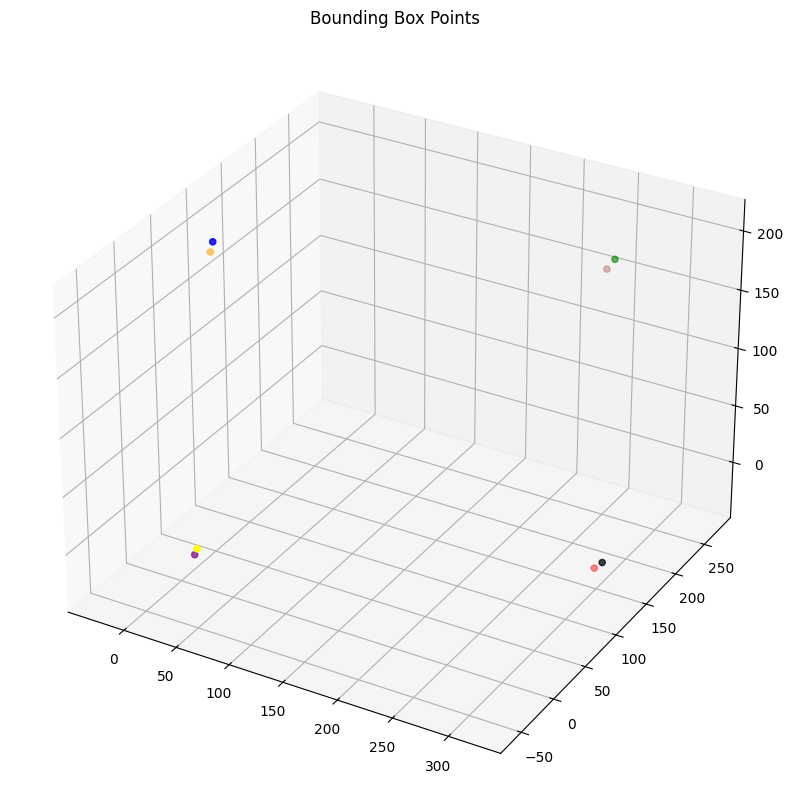

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

ax.scatter(bbox_points[:,0], bbox_points[:,1], bbox_points[:,2], color=["blue", 
                                                                        "green", 
                                                                        "yellow", 
                                                                        "orange", 
                                                                        "red", 
                                                                        "purple", 
                                                                        "brown", 
                                                                        "black"])
plt.title("Bounding Box Points")

plt.show()

In [13]:
# Visualizing the point cloud
o3d.visualization.draw([viz_pcd_cropped, bbox])

## Rotation-Matrix Creation from bounding box points

In the case the standard or built-in rotation-matrix function is not operating as we wish, there also is the possibility to retrieve the eight points that define the bounding box, or possibly the axes of the bounding box as a shorter cut, and then determining the rotation-matrix and the translation by oneself.<br>
Just keep in mind, there si the risk of gimbal lock, therefore some research should be done on how big the risk is and whether immedeate mitigation a has to take place.

In [ ]:
# Get rotation matrix from oriented bounding box

# Multiplication for actual input point cloud rotation

# visualization to check for axis alignment

## Quaternion-Rotation of the input point cloud

The Quaternion-rotation is at first a little unintuitive, but essentially it is the complex numbers for three-dimensional systems. Therefore, as with the complex numbers in 2D the rotation of a vector/ object can be completed in this 4D system. In order to define whether that is the best solution for our problem a little more research has to be done though.

In [ ]:
# Get Quaternion rotation function/ matrix

# Rotate point cloud and visualize again to check for axis alignment